In [1]:
import jax.numpy as jnp
from jax import grad, vmap
import jax
from jax.tree_util import tree_map
import jax.random as jrandom
import jax.scipy as scipy
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
from typing import NamedTuple, Mapping
from functools import partial

In [2]:
class Model(NamedTuple):
    dim: int
    log_prior: Mapping
    log_likelyhood: Mapping
    t_inv_map: Mapping
    jac_t_inv_map: Mapping
    det_jac_t_inv_map: Mapping

In [19]:
def mean_field_obj(param, sample, model):
    mu = param["mu"]
    sigma = param["log_sigma"]
    sample = sample * sigma + mu
    log_likelyhood = model.log_likelyhood(sample)
    log_prior = model.log_prior(sample)
    det_jac = jnp.abs(model.det_jac_t_inv_map(sample))
    entropy = 0.5 * jnp.sum(jnp.log((2 * jnp.pi * jnp.e) * sigma**2))
    return log_likelyhood + log_prior + jnp.log(det_jac) + entropy


mean_field_grad = jax.grad(mean_field_obj, argnums=0)
mean_field_grad_val = jax.value_and_grad(mean_field_obj, argnums=0)
v_mean_field_grad_val = jax.vmap(
    mean_field_grad_val,
    in_axes=(None, 0, None),
    out_axes=(0, {"mu": 0, "log_sigma": 0}),
)


def adaptive_step_size(iter, s_k, grads, stepsize=0.5, momentum=0.1, tau=1):
    s_kplus = jax.tree_map(
        lambda x, y: momentum * x**2 + (1 - momentum) * y, grads, s_k
    )
    lead_const = stepsize * (iter + 1) ** (-0.5 + 1e-6)
    rho_k = jax.tree_map(lambda x: lead_const / (tau + x), s_kplus)
    return rho_k, s_kplus


@jax.jit
def sgd_update_params(params, new_params, step_size):
    return jax.tree_map(lambda x, y, z: x + z * y, params, new_params, step_size)


class mean_field_advi:
    def __init__(self, model: Model) -> None:
        self.model = model
        self.params = {
            "mu": jnp.zeros((self.model.dim,)) * 1.0,
            "log_sigma": jnp.ones((self.model.dim,)) * 1.0,
        }
        self.old_params_grad = jax.tree_map(lambda x: jnp.zeros_like(x), self.params)
        self.obj_fun = mean_field_obj
        self.grad_fun = jax.grad(mean_field_grad)

    def sgd_update_params(self, params, new_params, step_size):
        return jax.tree_map(lambda x, y, z: x + z * y, params, new_params, step_size)

    def run_advi(
        self,
        key,
        num_sample,
        num_iter,
        learning_rate,
        print_every=100,
        alpha=0.1,
        adaptive=False,
    ):
        loss_val = []
        jit_wrapper = lambda x, y: v_mean_field_grad_val(x, y, self.model)
        val_grad = jax.jit(jit_wrapper)
        for i in range(num_iter):
            key, _ = jrandom.split(key)
            samples = jrandom.normal(key, shape=(num_sample, self.model.dim))
            vals, grads = val_grad(self.params, samples)

            loss_val.append(jnp.mean(vals))
            mean_grad = jax.tree_map(lambda x: jnp.mean(x, axis=0), grads)
            if adaptive:
                if i == 0:
                    s_k = jax.tree_map(lambda x: x**2, mean_grad)
                step_size, s_k = adaptive_step_size(
                    i, s_k, mean_grad, stepsize=learning_rate, momentum=alpha
                )

            step_size = jax.tree_map(
                lambda x: learning_rate * jnp.ones(x.shape), self.params
            )
            self.params = sgd_update_params(self.params, mean_grad, step_size)

            if i % print_every == 0:
                print(loss_val[-1])
                # break
        return loss_val

In [20]:
def LinearModel(X, y, a_zero, b_zero):
    dim = X.shape[1] + 1

    def t_inv_map(param):
        # Mapping from R^d to R^{d-1} \times R_{++}
        return param[: dim - 1], jnp.exp(param[dim - 1])

    def log_prior(param):
        w, sigma = t_inv_map(param)
        log_w_proba = jnp.sum(stats.norm.logpdf(w, 0, sigma))
        log_sigma_proba = stats.gamma.logpdf(sigma / a_zero, b_zero) - jnp.log(a_zero)
        return log_w_proba + log_sigma_proba

    def log_likelyhood(param):
        w, sigma = t_inv_map(param)
        preds = X @ w
        proba = jnp.sum(stats.norm.logpdf(y, preds, sigma))
        return proba

    def det_jac_t_inv_map(param):
        return jnp.trace(jac_t_inv_map(param))

    def jac_t_inv_map(param):
        to_return = jnp.eye(dim)
        to_return = to_return.at[dim - 1, dim - 1].set(jnp.exp(param[dim - 1]))
        return to_return

    return Model(
        dim=dim,
        log_prior=log_prior,
        log_likelyhood=log_likelyhood,
        t_inv_map=t_inv_map,
        jac_t_inv_map=jac_t_inv_map,
        det_jac_t_inv_map=det_jac_t_inv_map,
    )


def NMF_Model_PoissonExpGamma(
    data, rank, gamma_prior_shape, gamma_prior_scale, exp_prior
):
    num_samples, num_dims = data.shape
    dim = num_samples * rank + rank * num_dims

    def t_inv_map(params):
        theta, beta = jnp.split(params, [num_samples * rank])
        theta = jnp.reshape(theta, (num_samples, rank))
        beta = jnp.reshape(beta, (rank, num_dims))
        theta = jnp.exp(theta + 1)
        beta = jnp.exp(beta + 1)
        return theta, beta
    
    # def jac_t_inv_map(params):
    #     return jnp.diag(1+0.0*params)

    # def det_jac_t_inv_map(params):
    #     return jnp.sum(1+0.0*params)
    def jac_t_inv_map(params):
        return jnp.diag(jnp.exp(params + 1))

    def det_jac_t_inv_map(params):
        return jnp.sum(jnp.exp(params + 1))

    def log_prior(params):
        theta, beta = t_inv_map(params)
        # theta_prior = stats.expon.logpdf(theta,exp_prior)
        theta_prior = stats.gamma.logpdf(
            theta/gamma_prior_scale, gamma_prior_shape) - jnp.log(gamma_prior_scale)
        beta_prior = stats.gamma.logpdf(
            beta/gamma_prior_scale, gamma_prior_shape) - jnp.log(gamma_prior_scale)
        return jnp.sum(theta_prior) + jnp.sum(beta_prior)

    def log_likelyhood(params):
        theta, beta = t_inv_map(params)
        reconst = theta @ beta
        log_like = stats.poisson.logpmf(data, reconst)
        return jnp.sum(log_like)

    return Model(
        dim=dim,
        log_prior=log_prior,
        log_likelyhood=log_likelyhood,
        t_inv_map=t_inv_map,
        jac_t_inv_map=jac_t_inv_map,
        det_jac_t_inv_map=det_jac_t_inv_map,
    )

In [21]:
N = 100
d = 3
key = jrandom.key(42)
k1, k2, k3 = jrandom.split(key, 3)
X_data = jrandom.normal(k1, shape=(N, d))
w_star = jrandom.normal(k2, shape=(d,)) * 2
y = X_data @ w_star
linear_model = LinearModel(X_data, y, 1, 1)
trial_param = jrandom.normal(k3, shape=(d + 1,))
linear_advi = mean_field_advi(linear_model)
key = jrandom.key(52)
loss = linear_advi.run_advi(key, 100, 1000, 1e-4, print_every=20)
print(linear_advi.params)
print(w_star)

-2103.2507
-268.53986
-257.477
-249.92998
-251.28073
-245.5511
-243.72797
-236.59761
-234.89201
-237.38034
-228.41023
-223.54468
-226.11282
-218.55197
-215.8785
-209.14627
-209.15172
-202.49005
-197.68745
-192.67487
-192.48598
-183.7798
-179.11107
-173.95503
-162.67328
-154.89113
-144.74986
-135.1396
-127.25354
-112.5523
-101.203125
-86.48305
-71.71227
-58.201263
-49.166668
-40.422005
-35.318653
-32.001637
-30.176144
-28.904795
-28.144379
-28.158176
-27.7532
-27.928617
-27.990892
-27.734621
-27.367243
-27.459135
-27.78812
-27.869442
{'log_sigma': Array([0.03068081, 0.03136487, 0.03249675, 0.06949067], dtype=float32), 'mu': Array([-1.9901353, -1.7312784, -1.2939295, -1.2142645], dtype=float32)}
[-2.0137007 -1.7523379 -1.3056182]


In [22]:
from scipy.io import loadmat

data = loadmat("data/frey_rawface.mat")["ff"].T[:100]

In [33]:
print(betas.shape)

(10, 560)


In [29]:
rank = 10
nmf_model = NMF_Model_PoissonExpGamma(
    data, rank, gamma_prior_shape=1, gamma_prior_scale=1, exp_prior=1
)
nmf_dim = nmf_model.dim
k = jrandom.key(15)
trial_vec = jrandom.normal(k, shape=(nmf_dim,))
theta, beta = nmf_model.t_inv_map(trial_vec)
nmf_advi = mean_field_advi(nmf_model)
nmf_advi.run_advi(k, 20, 15000, 1e-5, print_every=100, adaptive=True)

# print(theta.shape, beta.shape)
# print(jnp.sum(nmf_model.log_prior(trial_vec)))
# print(jnp.sum(nmf_model.log_likelyhood(trial_vec)))
# print(jnp.sum(nmf_model.jac_t_inv_map(trial_vec)))
# print(jnp.sum(nmf_model.det_jac_t_inv_map(trial_vec)))

-2478957.8
-683712.3
-490713.06
-408535.47
-362530.72
-335745.97
-317718.22
-306426.06
-299479.44
-294194.6
-290758.34
-288840.4
-287012.4
-286223.47
-285610.22
-285166.75
-284814.84
-284735.1
-284342.0
-284383.97
-284312.28
-284171.53
-284092.84
-283977.5
-283980.22
-283782.47
-283479.84
-283247.72
-282773.72
-282129.06
-281260.66
-280092.8
-278518.16
-276570.12
-274450.62
-272281.97
-270300.06
-268322.34
-266605.1
-265131.06
-263595.62
-262424.0
-261286.16
-260388.3
-259603.5
-258862.28
-258108.4
-257480.0
-256803.03
-256073.12
-255567.75
-254926.25
-254236.25
-253689.3
-252928.75
-252282.8
-251687.2
-251087.62
-250411.25
-249831.11
-249280.4
-248744.2
-248171.8
-247753.0
-247243.75
-246715.2
-246315.7
-245892.66
-245522.42
-245107.78
-244713.5
-244381.08
-244032.12
-243748.33
-243404.36
-243110.38
-242923.55
-242620.98
-242362.98
-242089.61
-241888.25
-241779.0
-241467.73
-241284.86
-241081.2
-240932.3
-240775.95
-240586.42
-240434.4
-240317.62
-240174.11
-240027.11
-239873.4
-23972

KeyboardInterrupt: 

In [30]:
key2 = jrandom.key(19)
sample = jrandom.normal(key2)*nmf_advi.params["log_sigma"]+nmf_advi.params["mu"]
thetas,betas  = nmf_model.t_inv_map(sample)

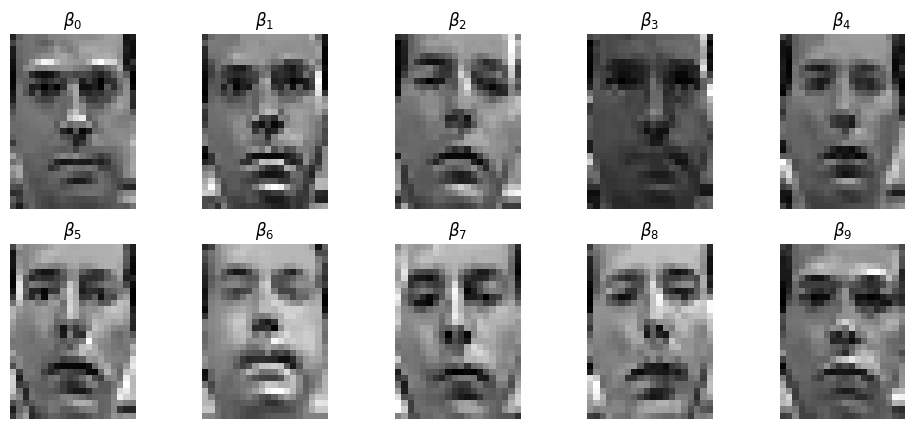

In [32]:
u = 42

fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(betas[i].reshape(28, 20), cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(rf"$\beta_{{{i}}}$")

# u = 42
# plt.figure()
# plt.subplot(121)
# plt.imshow((thetas[u] @ betas).reshape(28, 20), cmap="gray")
# plt.axis("off")
# plt.title(rf"$\theta_{{{u}}}\cdot\beta$")
# plt.subplot(122)
# plt.imshow(data[u].reshape(28, 20), cmap="gray")
# plt.title(rf"$Y_{{{u}, true}}$")
# plt.axis("off")
# print(f"theta_{u}: {thetas[u]}")

theta_25: [ 3.787185    1.7161064   1.9514723   2.010833    0.72289276  2.4860988
 40.863503    2.979187    2.6782737   6.2087507 ]


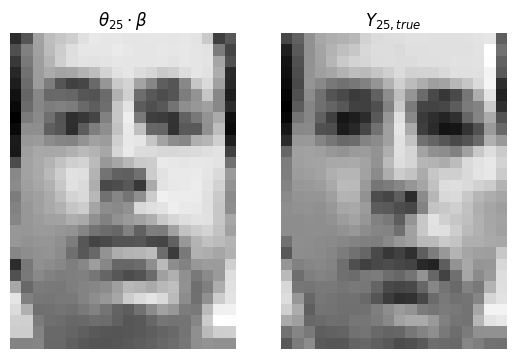

In [34]:
u = 25
plt.figure()
plt.subplot(121)
plt.imshow((thetas[u] @ betas).reshape(28, 20), cmap="gray")
plt.axis("off")
plt.title(rf"$\theta_{{{u}}}\cdot\beta$")
plt.subplot(122)
plt.imshow((thetas[u-10] @ betas).reshape(28, 20), cmap="gray")
plt.title(rf"$Y_{{{u}, true}}$")
plt.axis("off")
print(f"theta_{u}: {thetas[u]}")